In [17]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [2]:
import os
import h5py
import sys
sys.path.append("../..") 
import numpy as np
from cryoem.quaternions import euler2quaternion, d_q, quaternion2euler
# from cryoem.rotation_matrices import euler2matrix, matrix2euler, d_r
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product

from cryoem.angle_alignment import distance_difference

In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")
      
angles_true = np.array(data['Angles'])
projections = data['Projections']
      

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles.npy")

In [5]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Mean `quaternion` distance between true and predicted values: 1.820 rad (104.296 degrees)
Mean `rotation matrix` distance between true and predicted values: 1.820 rad (104.296 degrees)


(1.820303758799054, 1.8203037587990518)

---

---

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_r(\begin{bmatrix}
1 & 0\\
0 & R_i
\end{bmatrix}, R \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} \begin{bmatrix}
1 & 0\\
0 & \hat{R_i}
\end{bmatrix})
\end{equation}

- $d_R$ is the distance between two rotation matrices:

\begin{equation}
\label{eq:phase2}
 d_r(R_1, R_2) = \arccos{\frac{tr(R_1 R_2^T)-1}{2}}
\end{equation}

- $R_i \in SO(3)$ is the rotation matrix of a true rotation angles

- $\hat{R_i} \in SO(3)$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

In [6]:
def euler2matrix(angles):
    angles = tf.convert_to_tensor(angles)
    c1 = tf.reshape(tf.math.cos(angles[:,0]), (-1,1,1))
    c2 = tf.reshape(tf.math.cos(angles[:,1]), (-1,1,1))
    c3 = tf.reshape(tf.math.cos(angles[:,2]), (-1,1,1))
                
    s1 = tf.reshape(tf.math.sin(angles[:,0]), (-1,1,1))
    s2 = tf.reshape(tf.math.sin(angles[:,1]), (-1,1,1))
    s3 = tf.reshape(tf.math.sin(angles[:,2]), (-1,1,1))
     
    R = tf.concat([tf.concat([c1*c2*c3-s1*s3, c1*s3+c2*c3*s1 , -c3*s2],axis=2),\
                    tf.concat([-c3*s1-c1*c2*s3,    c1*c3-c2*s1*s3 ,   s2*s3],axis=2),\
                    tf.concat( [c1*s2,             s1*s2          ,   c2],axis=2)],axis=1)
    return R



def d_r(M1, M2):
    """Distance between 2 rotation matirces"""
    R = tf.linalg.matmul(M1, M2, transpose_b=True)
    mid = (tf.linalg.trace(R)-1)/2

    mid = tf.cast(mid, tf.float64)
    mid = tf.clip_by_value(mid, -1, 1)
    return tf.math.acos(mid)

In [7]:
def euler6tomarix4d(a_R):
    a, b, g, l, t, p = tf.unstack(a_R, axis=-1)
    
    ca = tf.cos(a)
    cb = tf.cos(b)
    cg = tf.cos(g)
    cl = tf.cos(l)
    ct = tf.cos(t)
    cp = tf.cos(p)
    
    sa = tf.sin(a)
    sb = tf.sin(b)
    sg = tf.sin(g)
    sl = tf.sin(l)
    st = tf.sin(t)
    sp = tf.sin(p)

   

    Ra = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(   ca, 0.0), tf.complex(  -sa, 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(   sa, 0.0), tf.complex(   ca, 0.0)], axis=0)]], axis=0)

    Rb = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex(   cb, 0.0), tf.complex([0.0], 0.0), tf.complex(   sb, 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex(  -sb, 0.0), tf.complex([0.0], 0.0), tf.complex(   cb, 0.0)], axis=0)]], axis=0)
    
    Rg = tf.concat([ [tf.concat([ tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex( cg, 0.0), tf.complex(-sg, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex( sg, 0.0), tf.complex( cg, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rl = tf.concat([ [tf.concat([ tf.complex( cl, 0.0), tf.complex([0.0], -sl), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -sl), tf.complex( cl, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rt = tf.concat([ [tf.concat([ tf.complex( ct, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], -st), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -st), tf.complex([0.0], 0.0), tf.complex( ct, 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)
    
    Rp = tf.concat([ [tf.concat([ tf.complex( cp, 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], -sp)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([ tf.complex([0.0], -sp), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex(cp, 0.0)], axis=0)]], axis=0)
    
    R = Ra @ Rb @ Rg @ Rl @ Rt @ Rp
    
    # TODO: check orthogonal
    # TODO: check if it is not complex even with different angles
    return R
    
    

def from3to4(mat):
    fill1 = tf.reshape([[0.0,0.0,0.0]]*mat.shape[0], (-1,3,1))
    mat_4d = tf.concat([fill1, mat], axis=2)
    fill2 = tf.reshape([[1.0,0.0,0.0,0.0]]*mat_4d.shape[0], (-1,1,4))
    out = tf.concat([fill2, mat_4d], axis=1)
    return tf.cast(out, dtype=tf.complex64)


def loss_alignment(m, a_R, a_predicted, a_true):
    Ri = tf.cast(euler2matrix(a_true), dtype=tf.float32)
    Ri_est = tf.cast(euler2matrix(a_predicted), dtype=tf.float32)
    
    Ri_4d = from3to4(Ri)
    Ri_est_4d = from3to4(Ri_est)
    R = euler6tomarix4d(a_R)
    
    I = tf.concat([ [tf.concat([tf.complex([m], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([1.0],0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)], 
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)

    R = tf.cast(R, dtype=tf.complex64)
    I = tf.cast(I, dtype=tf.complex64)
    
    
    second = R @ I @ Ri_est_4d
    # TODO: check if identity.

    second = tf.cast(second, tf.float64)
    Ri_4d = tf.cast(Ri_4d, tf.float64)
    
    distance = d_r(Ri_4d, second)
    
    return tf.reduce_mean(distance)


def gradient_alignment(m, a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted, optimization=True):
    optimizer = Adam(learning_rate=learning_rate)
    
    time_start = time()

    # collect rotations
    r = []
    # collect losses depending on rotation
    l = []
    ms = [-1.0, 1.0]

    for m in ms:
        losses = np.empty(steps)
        angles_predicted = tf.convert_to_tensor(ap)
    
        euler = np.zeros(6, dtype=np.float32)
        a_R = [tf.Variable(euler)]
        
        for step in range(1, steps+1):

            # Sample some pairs.
            idx = list(np.random.choice(projection_idx, size=batch_size))

            # Compute distances between projections
            a_true      = [angles_true[i]      for i in idx]
            a_predicted = [angles_predicted[i] for i in idx]

            # Optimize by gradient descent.
            if optimization:
                losses[step-1], gradients = gradient_alignment(m, a_R, a_predicted, a_true)
                optimizer.apply_gradients(zip(gradients, a_R))
            else:
                losses[step-1] = loss_alignment(m, a_R, a_predicted, a_true)

            # Periodically report progress.
            if ((step % (steps//10)) == 0) or (step == steps):
                time_elapsed = time() - time_start
                print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')
        print("-"*20)
        if optimization:
            # Plot convergence.
            fig, ax = plt.subplots()
            ax.plot(np.linspace(0, time()-time_start, steps), losses)
            ax.set_xlabel('time [s]')
            ax.set_ylabel('loss');
        else:
            print(f"Mean distance difference: {np.mean(losses)}")
         
        r.append(a_R)
        l.append(losses[-1])
        
    for i, m in enumerate([-1, 1]):
        print(f"For m={m}, loss is: {l[i]}")
    
    idx_best = np.argmin(np.array(l))
    return ms[idx_best], r[idx_best], l[idx_best]


step 100/1000 (10s): loss = 2.33e+00
step 200/1000 (20s): loss = 2.39e+00
step 300/1000 (30s): loss = 2.47e+00
step 400/1000 (43s): loss = 2.43e+00
step 500/1000 (53s): loss = 2.34e+00
step 600/1000 (64s): loss = 2.35e+00
step 700/1000 (73s): loss = 2.42e+00
step 800/1000 (82s): loss = 2.41e+00
step 900/1000 (92s): loss = 2.48e+00
step 1000/1000 (102s): loss = 2.41e+00
--------------------
step 100/1000 (113s): loss = 1.14e+00
step 200/1000 (122s): loss = 1.21e+00
step 300/1000 (132s): loss = 1.18e+00
step 400/1000 (142s): loss = 1.13e+00
step 500/1000 (155s): loss = 1.21e+00
step 600/1000 (168s): loss = 1.20e+00
step 700/1000 (177s): loss = 1.16e+00
step 800/1000 (186s): loss = 1.13e+00
step 900/1000 (196s): loss = 1.23e+00
step 1000/1000 (205s): loss = 1.15e+00
--------------------
For m=-1, loss is: 2.4096682449490117
For m=1, loss is: 1.1536665360185503


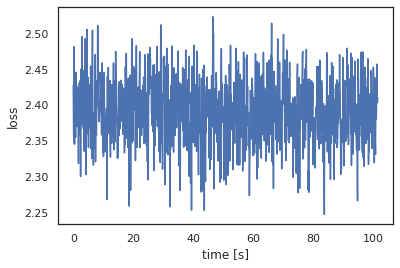

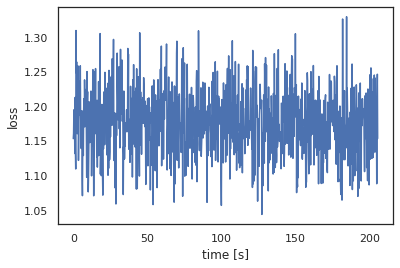

In [8]:
m, rotation, loss = training_angle_alignment(steps=1000, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap, 
                         optimization=True)

In [9]:
m, rotation, loss

(1.0, [<tf.Variable 'Variable:0' shape=(6,) dtype=float32, numpy=
  array([ 0.02019546, -0.04828779, -1.1267406 ,  0.        ,  0.        ,
          0.        ], dtype=float32)>], 1.1536665360185503)

In [11]:
def matrix2euler(mat):
    
    def _inner(m):
        # TRANSPOSED
        if m[2,2] < 1:
            if m[2,2] > -1:
                a2 = tf.acos(m[2,2])
                a1 = tf.atan2(m[1,2], m[0,2])
                a3 = tf.atan2(m[2,1], -m[2,0])
            else:
                a2 = tf.math.pi
                a1 = -tf.atan2(m[1,0], m[1,1])
                a3 = 0
        else:
            a2 = 0
            a1 = tf.atan2(m[1,0], m[1,1])
            a3 = 0
            
        return tf.stack([a1, a2, a3], axis=0)
    
    # TODO: WHAT TO DO WITH -1?? It is just cut bellow!!!!
    
    mat_vecs = tf.unstack(mat, axis=1)
    del mat_vecs[0]
    mat = tf.stack(mat_vecs, 1)
    
    mat_vecs = tf.unstack(mat, axis=2)
    del mat_vecs[0]
    mat = tf.stack(mat_vecs, axis=2)
    
    angles = []
    for m in mat:
        a = _inner(m).numpy()
        #a = np.array([a[0]%(2*np.pi), a[1]%(0.4*np.pi), a[2]%(2*np.pi)])
        angles.append(a)

    return np.array(angles)

In [12]:
def update_angles(m, a_R, a_predicted):
    Ri_est = tf.cast(euler2matrix(a_predicted), dtype=tf.float32)
    
    Ri_est_4d = from3to4(Ri_est)
    R = euler6tomarix4d(a_R)
    
    I = tf.concat([ [tf.concat([tf.complex([m], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([1.0],0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0)], axis=0)],
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0), tf.complex([0.0], 0.0)], axis=0)], 
                     [tf.concat([tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([0.0], 0.0), tf.complex([1.0], 0.0)], axis=0)]], axis=0)

    R = tf.cast(R, dtype=tf.complex64)
    I = tf.cast(I, dtype=tf.complex64)
    
    
    second = R @ I @ Ri_est_4d
    
    second = tf.cast(second, tf.float64)
    
    return matrix2euler(second)

In [13]:
updated_angles_true = update_angles(m, rotation, ap)
updated_angles_true

array([[ 1.44244767,  0.78079855, -2.86120303],
       [ 2.91062037,  0.57040287,  0.63087622],
       [-2.72700271,  0.25924434, -0.60602751],
       ...,
       [ 1.7204056 ,  1.06699857, -0.23610658],
       [-1.81458508,  0.68834702,  1.92388767],
       [-1.73859505,  0.8530784 , -2.93019758]])

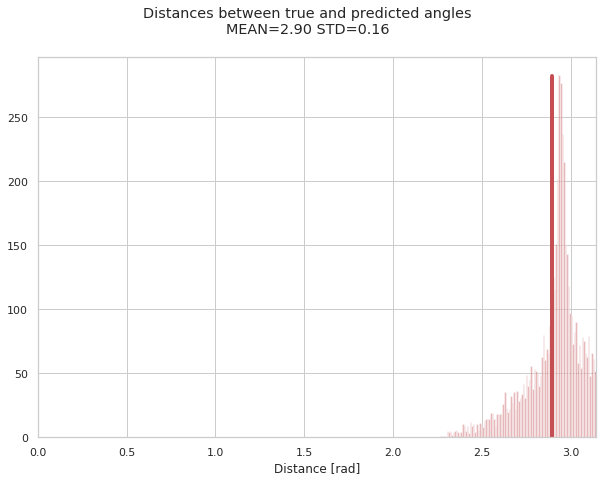

In [14]:
# TRANSPOSED
from cryoem.plots import plot_distances_count
plot_distances_count(updated_angles_true, angles_true)

In [15]:
np.savez(f"{PROTEIN}_projections_and_angles_rotmattest_T", projections, updated_angles_true)

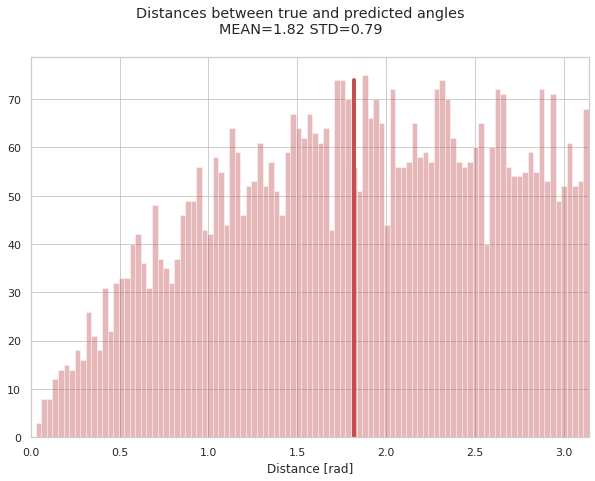

In [23]:
# NOT TRANSPOSED
from cryoem.plots import plot_distances_count
plot_distances_count(updated_angles_true, angles_true)

In [25]:
for i, a in enumerate(updated_angles_true):
    updated_angles_true[i] = [2*np.pi-a[0], a[1], 2*np.pi-a[2]]

In [26]:
updated_angles_true

array([[6.56964512, 0.76900193, 5.04031996],
       [3.75134496, 0.56509488, 6.53063988],
       [8.77129003, 0.26201123, 7.20425017],
       ...,
       [9.18961422, 1.05448776, 5.32215472],
       [5.0568564 , 0.69960637, 8.07743905],
       [6.48842506, 0.86471798, 8.15082088]])

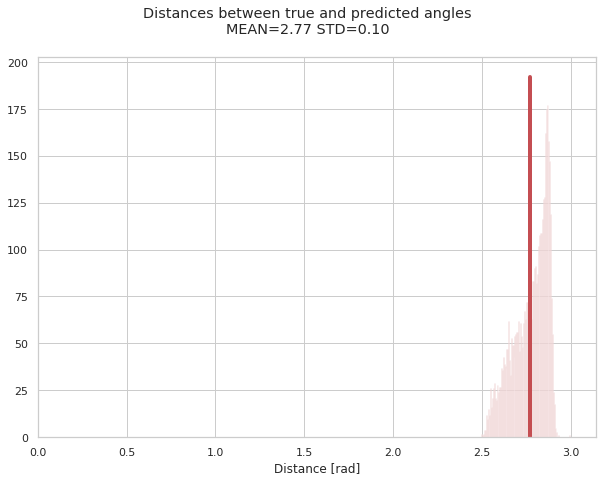

In [27]:
from cryoem.plots import plot_distances_count
plot_distances_count(updated_angles_true, angles_true)

In [13]:
angles_true

array([[2.74129289, 0.84906729, 5.48198312],
       [0.05198987, 0.52439503, 0.5559678 ],
       [5.01955447, 0.17657386, 1.26418297],
       ...,
       [5.3902725 , 1.07968313, 5.74111375],
       [1.17188032, 0.65006988, 2.25601305],
       [2.54509695, 0.82837041, 2.37254411]])

In [32]:
updated_angles_true

array([[6.56964512, 0.76900193, 5.04031996],
       [3.75134496, 0.56509488, 6.53063988],
       [8.77129003, 0.26201123, 7.20425017],
       ...,
       [9.18961422, 1.05448776, 5.32215472],
       [5.0568564 , 0.69960637, 8.07743905],
       [6.48842506, 0.86471798, 8.15082088]])

In [21]:
a = (updated_angles_true[:,0]%(2*np.pi)+updated_angles_true[:,2]%(2*np.pi))%(2*np.pi)
b = (angles_true[:,0]%(2*np.pi)+angles_true[:,2]%(2*np.pi))%(2*np.pi)
np.allclose(a, b, atol=1e-8)

False

In [20]:
a, b

(array([0.95640553, 2.28438577, 2.87401572, ..., 4.33778698, 5.71526047,
        4.21030998]),
 array([1.94009070e+00, 6.07957669e-01, 5.52133567e-04, ...,
        4.84820094e+00, 3.42789337e+00, 4.91764106e+00]))

In [41]:
np.where(~np.isclose(a, b, atol=1))

(array([   0,    1,    2, ..., 4996, 4997, 4999]),)

In [28]:
from cryoem.plots import plot_images
plot_images(updated_angles_true, projections, indices=range(100),img_size_scale=0.05)

In [29]:
np.savez(f"{PROTEIN}_projections_and_angles_rotmattest", projections, updated_angles_true)

In [21]:
from cryoem.plots import plot_images
plot_images(angles_true, projections, indices=range(100),img_size_scale=0.05)

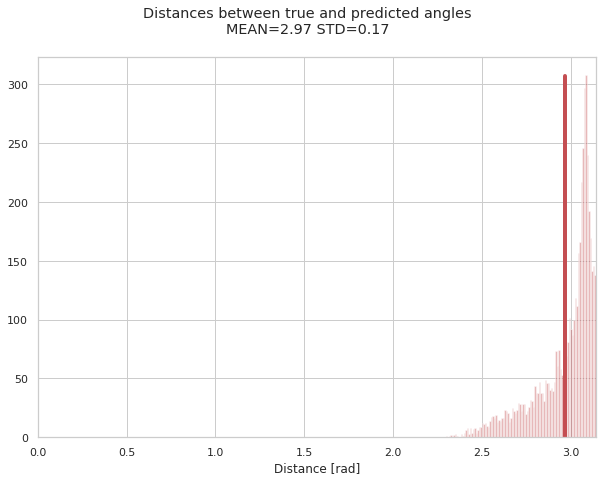

In [29]:
from cryoem.plots import plot_distances_count

plot_distances_count(updated_angles_true, angles_true)

### Tests

In [30]:
updated_angles_true = update_angles(1.0, [tf.Variable([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])], angles_true)
updated_angles_true

array([[-2.34039046,  0.84906731,  0.40029976],
       [ 2.58562487,  0.52439505,  3.08960278],
       [ 1.87740969,  0.17657388, -1.87796181],
       ...,
       [-2.5995211 ,  1.07968313, -2.24867984],
       [ 0.88557962,  0.65006991,  1.96971234],
       [ 0.76904859,  0.82837044,  0.59649569]])

In [32]:
angles_true

array([[2.74129289, 0.84906729, 5.48198312],
       [0.05198987, 0.52439503, 0.5559678 ],
       [5.01955447, 0.17657386, 1.26418297],
       ...,
       [5.3902725 , 1.07968313, 5.74111375],
       [1.17188032, 0.65006988, 2.25601305],
       [2.54509695, 0.82837041, 2.37254411]])

In [ ]:
a = (updated_angles_true[:,0]%(2*np.pi)+updated_angles_true[:,2]%(2*np.pi))%(2*np.pi)
b = (angles_true[:,0]%(2*np.pi)+angles_true[:,2]%(2*np.pi))%(2*np.pi)
np.allclose(a, b, atol=1e-8)

In [102]:
np.where(~np.isclose(a, b, atol=1e-8))

(array([], dtype=int64),)

In [91]:
updated_angles_true[3291]

array([2.13844291, 0.        , 0.        ])

In [92]:
angles_true[3291]

array([3.27606014e+00, 1.70744226e-04, 5.14556805e+00])

In [71]:
np.where(updated_angles_true[:,0]+updated_angles_true[:,2]- angles_true[:,0]-angles_true[:,2] > 1e-7)

(array([], dtype=int64),)

In [46]:
np.where(updated_angles_true-angles_true > 1e-1)

(array([3290]), array([0]))

In [50]:
updated_angles_true[3290][0]+ updated_angles_true[3290][2]

4.472590130322942

In [51]:
angles_true[3290][0]+ angles_true[3290][2]

4.472590121886887

In [ ]:
angles_true[3290][0]+ angles_true[3290][2]

In [10]:
mat = update_angles(m, rotation, ap)
mat

array([[-0.35896667,  0.85239956,  0.88504649],
       [ 2.35898177,  0.52359487, -0.50727969],
       [-2.70484795,  0.17484034, -1.11706342],
       ...,
       [-2.99004596,  1.11956645,  0.59213057],
       [ 1.30576569,  0.61377003, -2.26506979],
       [-0.13145257,  0.78233413, -2.32566938]])

In [22]:
mat = update_angles(1.0, r, angles_true)

In [23]:
mat

array([[-0.80120219,  0.84906731,  2.7412929 ],
       [ 0.55596778,  0.52439505,  0.05198987],
       [ 1.26418297,  0.17657388, -1.26363084],
       ...,
       [-0.54207155,  1.07968313, -0.89291282],
       [ 2.25601304,  0.65006991,  1.17188032],
       [ 2.37254406,  0.82837044,  2.54509696]])

In [12]:
distance_difference(angles_predicted=mat, angles_true=angles_true);

Mean `quaternion` distance between true and predicted values: 0.000 rad (0.000 degrees)
Mean `rotation matrix` distance between true and predicted values: 0.000 rad (0.000 degrees)


In [48]:
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images, plot_selected_angles_with_3rd_angle_magnitude

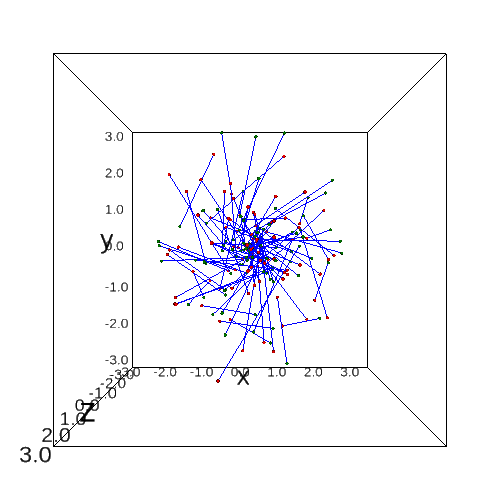

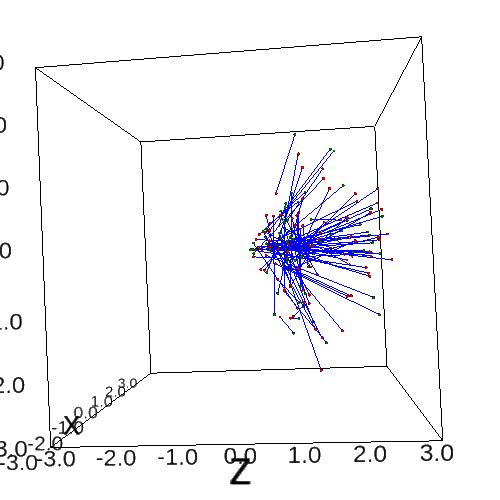

In [49]:
plot_selected_angles_with_3rd_angle_magnitude(mat, angles_true, range(100))

In [38]:
import ipyvolume as ipv

In [51]:
display(ipv.screenshot())

Output()

In [52]:
plot_images(mat, projections, indices=range(100),img_size_scale=0.05)

In [44]:
display(ipv.screenshot())

Output()

---

# Misc testing

Alignment method: adding angles to predicted angles directly, and not multiplying rotations.

In [4]:
def lossR(a_R, a_predicted, a_true):
    ap = tf.math.add(a_predicted, a_R)
    q_predicted = euler2quaternion(ap)
    q_true = euler2quaternion(a_true)

    distance = d_q(q_true, q_predicted)
    
    return tf.reduce_mean(distance)

def gradientR(a_R, a_predicted, a_true):
    with tf.GradientTape() as tape:
        loss_value = lossR(a_R, a_predicted, a_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient

def training_angle_alignment_R(steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted, optimization=True):
    optimizer = Adam(learning_rate=learning_rate)

    losses = np.empty(steps)
    time_start = time()

    euler = np.zeros(3, dtype=np.float64)
    a_R = [tf.Variable(euler)]

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(projection_idx, size=batch_size))
        
        # Compute distances between projections
        a_true = [angles_true[i] for i in idx]
        a_predicted = [angles_predicted[i] for i in idx]
        
        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradientR(a_R, a_predicted, a_true)
            optimizer.apply_gradients(zip(gradients, a_R))
        else:
            losses[step-1] = lossR(a_R, a_predicted, a_true)

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-(steps//10):step-1]):.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean distance difference: {np.mean(losses)}")

    return a_R, np.mean(losses[step-(steps//10):step-1])

def training_angle_alignment_R_flips(steps, batch_size, projection_idx, learning_rate, angles_true, ap, optimization=True):
    flips = {}

    # (1, -1, 1) -> loss
    for z0_flip, y1_flip, z2_flip in list(product([1, -1], repeat=3)):
    
        print(f"FLIPPING: {z0_flip, y1_flip, z2_flip}")

        ap_new = np.zeros(ap.shape)
        for i, a in enumerate(ap):
            ap_new[i] = [z0_flip*a[0], y1_flip*a[1], z2_flip*a[2]]
            
        angles_predicted = tf.convert_to_tensor(ap_new)

        a_R, loss = training_angle_alignment_R(steps=steps, 
                                    batch_size=batch_size,
                                    projection_idx=projection_idx,
                                    learning_rate=learning_rate,
                                    angles_true=angles_true,
                                    angles_predicted=angles_predicted,
                                    optimization=True)
        
        print(f"Rotation: {a_R[0].numpy()};  Loss: {loss}")
        flips[(z0_flip, y1_flip, z2_flip)] = (a_R, loss)
    
    best_flips = min(flips, key=lambda x: flips.get(x)[1])
    return best_flips, flips[best_flips]

def updateR_alignment(flips, ap, a_R):
    ap_new = np.zeros(ap.shape)
    for i, a in enumerate(ap):
        ap_new[i] = [flips[0]*a[0], flips[1]*a[1], flips[2]*a[2]]

    angles_predicted = tf.convert_to_tensor(ap_new)

    q_predicted = euler2quaternion(angles_predicted)
    q_R = euler2quaternion(a_R)

    angles_predicted_new = quaternion2euler(quaternion.multiply(q_predicted, q_R))
    return angles_predicted_new

def distance_difference(angles_predicted, angles_true):
    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)
    qd = np.mean(d_q(q_predicted, q_true).numpy())
    print(f"Mean quaternion distance between true and predicted values: {qd} rad ({np.degrees(qd):.2f} degrees)")

    return qd


In [5]:
distance_difference(ap, angles_true);

Mean quaternion distance between true and predicted values: 1.8203037587990536 rad (104.30 degrees)


FLIPPING: (1, 1, 1)
step 1000/10000 (62s): loss = 1.81e+00
step 2000/10000 (122s): loss = 1.80e+00
step 3000/10000 (184s): loss = 1.80e+00
step 4000/10000 (245s): loss = 1.81e+00
step 5000/10000 (309s): loss = 1.81e+00
step 6000/10000 (372s): loss = 1.80e+00
step 7000/10000 (435s): loss = 1.81e+00
step 8000/10000 (503s): loss = 1.81e+00
step 9000/10000 (568s): loss = 1.80e+00
step 10000/10000 (634s): loss = 1.81e+00
Rotation: [ 1.30460189 -0.13881971  0.64301416];  Loss: 1.8059127340227028
FLIPPING: (1, 1, -1)
step 1000/10000 (65s): loss = 1.56e+00
step 2000/10000 (131s): loss = 1.56e+00
step 3000/10000 (196s): loss = 1.56e+00
step 4000/10000 (262s): loss = 1.56e+00
step 5000/10000 (326s): loss = 1.55e+00
step 6000/10000 (389s): loss = 1.56e+00
step 7000/10000 (453s): loss = 1.56e+00
step 8000/10000 (514s): loss = 1.56e+00
step 9000/10000 (575s): loss = 1.55e+00
step 10000/10000 (637s): loss = 1.56e+00
Rotation: [ 1.77026620e+00  1.03457350e-03 -1.92411812e-01];  Loss: 1.55587053144986

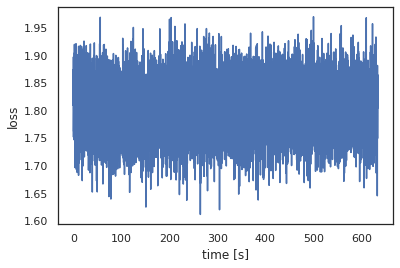

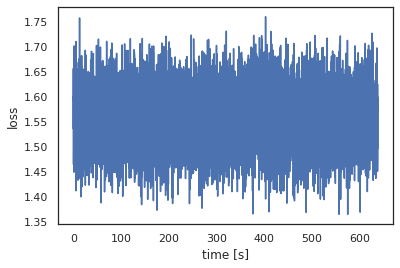

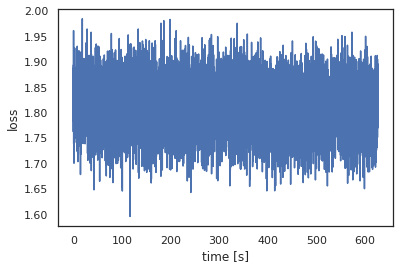

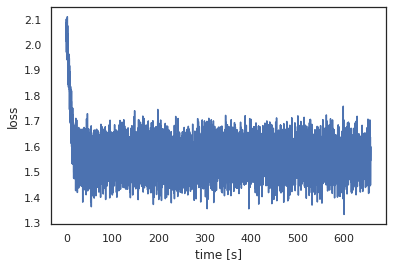

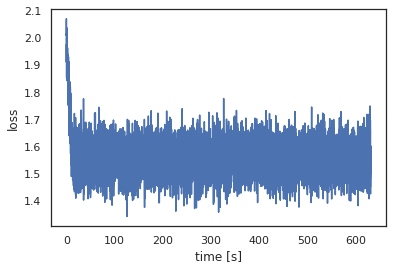

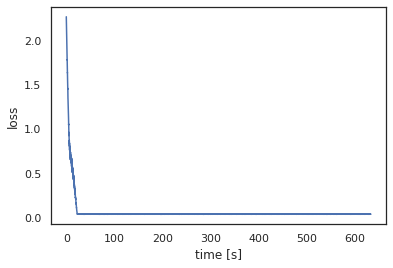

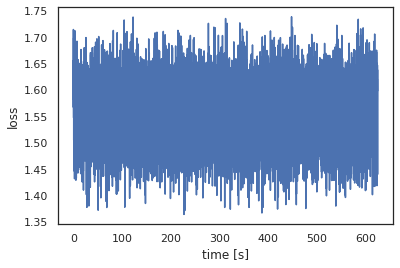

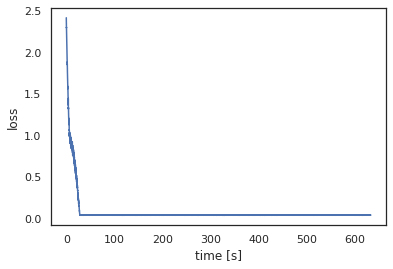

In [6]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=10000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [9]:
flips, (a_R, loss)

((-1, 1, -1),
 ([<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([ 2.42507828e+00,  6.49478306e-04, -2.11279940e-01])>],
  0.03807980045359422))

In [8]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [10]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Mean quaternion distance between true and predicted values: 1.185072951673217 rad (67.90 degrees)


1.185072951673217

---